# A Lightweight Spectral-Spatial Convolution Module for Hyperspectral Image Classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.model_selection
from torch.nn import init
from torch.backends import cudnn
from operator import truediv
from tqdm import tqdm
import os
from scipy import io
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from timm.layers import weight_init, DropPath
from timm.models.registry import register_model
import random
import time
import math
from thop import profile
from torchsummary import summary
device = torch.device('cuda:{}'.format(0))
random.seed(7)
torch.manual_seed(7)
torch.cuda.manual_seed(7)
np.random.seed(7)
cudnn.deterministic = True

# 1. Load data

## 1.1 Load img and gt as numpy.ndarray

In [2]:
datasets = {
        'PaviaU': {
            'img': 'PaviaU.mat',      #paviaU
            'gt': 'PaviaU_gt.mat'     #paviaU_gt
            },
        'houston2013':{
            'img': 'houston2013.mat', # houston2013
            'gt': 'DFC2013_gt.mat'# DFC2013_gt
        },
        'salinas':{
            'img': 'Salinas.mat', # salinas
            'gt': 'Salinas_gt.mat'# salinas_gt
        },
        'WHHC':{
            'img': 'hanchuan_half.mat', # hanchuan_half
            'gt': 'hanchuan_half_gt.mat'# half_new
        }, 
        'Dioni':{
            'img': 'Dioni.mat', # ori_data
            'gt': 'Dioni_gt_out68.mat'# map
        } 
}
dataset_name='Dioni'
dataset=datasets[dataset_name]
folder = './Datasets/'
img = io.loadmat(folder+dataset['img'])['ori_data']   

img= (img - np.min(img))/(np.max(img)-np.min(img))  
print(type(img),img.shape)
gt = io.loadmat(folder + dataset['gt'])['map']

<class 'numpy.ndarray'> (250, 1376, 176)


## 1.2 Visualization

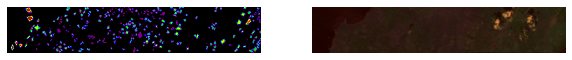

In [3]:
N_CLASSES = max(np.unique(gt))
N_BANDS = img.shape[-1]      
fig=plt.figure(num=1,figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(gt,cmap='nipy_spectral')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(img[:,:,(10, 50, 100)]) 
# plt.imshow(img[:,:,(10, 20, 30)]) 
plt.axis('off')
plt.show()

## 1.3 Training set ,validation set and test set split

In [4]:
indices = np.nonzero(gt)
X = list(zip(*indices))
y = gt[indices] 
train_gt = np.zeros_like(gt)
test_gt = np.zeros_like(gt)
val_gt = np.zeros_like(gt)
print('train_gt: ',type(train_gt),train_gt.shape)

train_indices, test_indices = sklearn.model_selection.train_test_split(X, train_size=0.03, random_state=12,stratify=y)

val_size = len(train_indices)
val_indices = test_indices[-val_size:]
test_indices = test_indices[:-val_size]

train_size = len(train_indices)
train_indices = list(zip(*train_indices))
val_indices = list(zip(*val_indices))
test_indices = list(zip(*test_indices))

train_gt[train_indices] = gt[train_indices]
val_gt[val_indices] = gt[val_indices]
test_gt[test_indices] = gt[test_indices]

# GHOSTNET&LS2CM Training set for hous2013
# train_gt = io.loadmat(folder+'TR_hous2013_5.mat')['Tr1'] 
# val_gt = io.loadmat(folder+'TV_hous2013_5.mat')['Tv1'] 
# test_gt = io.loadmat(folder+'TE_hous2013_5.mat')['Te_new1'] 


train_gt:  <class 'numpy.ndarray'> (250, 1376)


D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result e

## 1.4 Define dataloader

In [5]:
class HSIdata(torch.utils.data.Dataset):
    def __init__(self,data,gt):
        super(HSIdata, self).__init__()
        self.data = data   
        self.label = gt-1
        self.patch_size = 11
        self.data_all_offset = np.zeros((data.shape[0] + self.patch_size - 1, self.data.shape[1] + self.patch_size - 1, self.data.shape[2]))
        self.start = int((self.patch_size - 1) / 2)
        self.data_all_offset[self.start:data.shape[0] + self.start, self.start:data.shape[1] + self.start, :] = self.data[:, :, :]
        x_pos, y_pos = np.nonzero(gt)
    
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        self.labels = [self.label[x,y] for x,y in self.indices]
        
#         np.random.shuffle(self.indices)
        
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size

        data = self.data_all_offset[x:x+self.patch_size, y:y+self.patch_size]
        label = self.label[x, y]
        data = np.asarray(data.transpose((2, 0, 1)), dtype='float32')
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
#         print(type(data[6,6,1]),data.shape)
#         print(label)
        return data, label,x,y

train_dataset = HSIdata(img, train_gt)
train_loader = torch.utils.data.DataLoader(train_dataset,
                               batch_size=32,
                               shuffle=True)

val_dataset = HSIdata(img, val_gt)
val_loader = torch.utils.data.DataLoader(val_dataset,
                               batch_size=32,
                               shuffle=True)

test_dataset = HSIdata(img, test_gt)
test_loader = torch.utils.data.DataLoader(test_dataset,
                               batch_size=256,
                               shuffle=True)

all_gt_dataset = HSIdata(img,gt)
all_loader = torch.utils.data.DataLoader(all_gt_dataset,
                               batch_size=256,
                               shuffle=True)


# 2. Define Network structure 

In [6]:

class LS2CM(nn.Module):
    def __init__(self, input_channels ,output_channels, relu=True):
        super(LS2CM, self).__init__()
        reduction_N = math.ceil(output_channels / 2)
        self.point_wise = nn.Conv2d(input_channels,reduction_N,kernel_size=1,padding=0)
        self.depth_wise = nn.Conv2d(reduction_N, reduction_N, kernel_size=3, padding=1, groups=reduction_N)      
        self.relu = nn.ReLU(inplace=True) if relu else nn.Sequential()
        self.bn = nn.BatchNorm2d(output_channels)
    def forward(self,x):
        x_1 = self.point_wise(x)  
        x_2 = self.depth_wise(x_1)
        x = torch.cat((x_2,x_1),dim=1)
        x = self.bn(x)
        x = self.relu(x)
        return x


class ResLS2CM(nn.Module):
    def __init__(self, inp, oup):
        super(ResLS2CM, self).__init__()

        self.ResBlock = nn.Sequential(
            LS2CM(inp, oup, relu=True),
            LS2CM(oup, oup, relu=False),
        )
        
        if inp == oup:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        return self.ResBlock(x) + self.shortcut(x)    
    
    
class BaseNet(nn.Module):

    def __init__(self, input_channels, n_classes):
        super(BaseNet, self).__init__()

        self.stem = nn.Conv2d(input_channels, 16, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()        
        
        self.Block1 = ResLS2CM(16,16)
        self.Block2 = ResLS2CM(16,32)
        self.Block3 = ResLS2CM(32,64)
             
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(64, n_classes)

    def forward(self, x):

        x1 = self.stem(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        
        x2 = self.Block1(x1)
        x2 = self.Block2(x2)
        x2 = self.Block3(x2) 
            
        x3 = self.avgpool(x2)
        x3 = x3.view(x3.size(0), -1)
        x3 = self.fc1(x3)
        
        return x3


# 3. Utils

In [7]:
def save_model(model, model_name, dataset_name, epoch):
    model_dir = './checkpoints/' + model_name + "/" + dataset_name + "/"
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir, exist_ok=True)
    filename = str('w6') + "_epoch{}".format(epoch)
    print(filename)
    torch.save(model.state_dict(), model_dir + filename + '.pth')
    
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

# 4. Train define

In [8]:
def evaluate_accuracy(data_loader, net, loss):
#     val_loss = 0
    number = 0
    acc_sum = 0   
    test_num = 0
    with torch.no_grad():
        for iter_, (data, target,x,y) in enumerate(data_loader):
            val_loss = 0
            data, target = data.to(device), target.to(device)            
            net.eval()
            output = net(data)
            l = loss(output, target.long())
            acc_sum += (output.argmax(dim=1) == target.to(device)).float().sum().cpu().item()          
#             l = loss(output, target)
#             _, predicts = torch.max(output.data, 1)
            val_loss = val_loss + l
            number += len(target)
#             correct = correct + (predicts == target).sum()
            net.train()
            test_num += 1
        
    return [acc_sum / number, val_loss.cpu()]


def train(net, optimizer, critirian, data_loader, val_loader, epoch):
    loss_list = [1000]
    early_epoch = 0
    early_num = 20 
    early_stopping = 1
    train_loss_list = []
    valida_loss_list = []
    train_acc_list = []
    valida_acc_list = []
    net.to(device)
    for e in range(1, epoch + 1):
        net.train()
        lr_adjust = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 15, eta_min=0.0, last_epoch=-1)
        avg_loss = 0
        number = 0
        correct = 0
        for iter_, (data, target,x,y) in enumerate(data_loader):
            batch_count, train_l_sum = 0, 0
            data, target = data.to(device), target.to(device)            
            optimizer.zero_grad()
            output = net(data)
            #             print(target)
            loss = critirian(output, target)
            loss.backward()
            optimizer.step()
            _, predicts = torch.max(output.data, 1)
            avg_loss = avg_loss + loss.item()
            number += len(target)
            correct = correct + (predicts == target).sum()
            
        lr_adjust.step(epoch)
        valida_acc, valida_loss = evaluate_accuracy(val_loader, net, critirian)
        loss_list.append(valida_loss)
        avg_loss /= len(data_loader)     
        print('train--------')
#         print('Epoch:', e, 'loss:', avg_loss)
        acc = correct.item() / number
    
        train_loss_list.append(avg_loss)
        train_acc_list.append(acc)
        valida_loss_list.append(valida_loss)
        valida_acc_list.append(valida_acc)

#         print('Epoch:', e, 'acc:', acc)
        print('epoch %d, train loss %.6f, train acc %.3f, valida  loss %.6f, valida acc %.3f'% (e + 1, avg_loss, acc, valida_loss, valida_acc))    
#         filename = str('LW') + "_epoch{}".format(e)
        PATH = "./LW_best_net.pt"
        global best_acc
        if valida_acc > best_acc:
            best_acc = valida_acc
            torch.save(net.state_dict(), PATH)
        if e == epoch:
            net.load_state_dict(torch.load(PATH))      
   
        if e % 100 == 0:
            save_model(net, 'basenet', dataset_name, e)



# 5.TRAIN & TEST

D:\anaconda3\envs\pytorch_envs\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train--------
epoch 2, train loss 2.013472, train acc 0.433, valida  loss 2.361205, valida acc 0.312
train--------
epoch 3, train loss 1.414355, train acc 0.640, valida  loss 2.626720, valida acc 0.312
train--------
epoch 4, train loss 1.196976, train acc 0.657, valida  loss 2.185678, valida acc 0.365
train--------
epoch 5, train loss 1.008075, train acc 0.733, valida  loss 1.133163, valida acc 0.663
train--------
epoch 6, train loss 0.946075, train acc 0.738, valida  loss 1.648743, valida acc 0.620
train--------
epoch 7, train loss 0.934502, train acc 0.722, valida  loss 2.709944, valida acc 0.313
train--------
epoch 8, train loss 0.802148, train acc 0.762, valida  loss 1.241330, valida acc 0.588
train--------
epoch 9, train loss 0.783514, train acc 0.772, valida  loss 1.770723, valida acc 0.383
train--------
epoch 10, train loss 0.698551, train acc 0.775, valida  loss 4.700307, valida acc 0.415
train--------
epoch 11, train loss 0.633498, train acc 0.813, valida  loss 1.388153, valid

train--------
epoch 83, train loss 0.240885, train acc 0.917, valida  loss 0.590554, valida acc 0.732
train--------
epoch 84, train loss 0.330916, train acc 0.887, valida  loss 1.079740, valida acc 0.740
train--------
epoch 85, train loss 0.269758, train acc 0.915, valida  loss 0.407663, valida acc 0.900
train--------
epoch 86, train loss 0.239325, train acc 0.920, valida  loss 2.426068, valida acc 0.600
train--------
epoch 87, train loss 0.228241, train acc 0.915, valida  loss 1.474737, valida acc 0.620
train--------
epoch 88, train loss 0.214958, train acc 0.930, valida  loss 2.057081, valida acc 0.553
train--------
epoch 89, train loss 0.229047, train acc 0.915, valida  loss 0.925072, valida acc 0.695
train--------
epoch 90, train loss 0.220961, train acc 0.923, valida  loss 16.663363, valida acc 0.145
train--------
epoch 91, train loss 0.202779, train acc 0.935, valida  loss 1.099531, valida acc 0.660
train--------
epoch 92, train loss 0.214708, train acc 0.927, valida  loss 2.8240

train--------
epoch 163, train loss 0.140114, train acc 0.958, valida  loss 0.570387, valida acc 0.775
train--------
epoch 164, train loss 0.122956, train acc 0.960, valida  loss 1.293956, valida acc 0.710
train--------
epoch 165, train loss 0.131809, train acc 0.958, valida  loss 0.321646, valida acc 0.833
train--------
epoch 166, train loss 0.094890, train acc 0.975, valida  loss 1.243291, valida acc 0.733
train--------
epoch 167, train loss 0.089777, train acc 0.977, valida  loss 0.388087, valida acc 0.923
train--------
epoch 168, train loss 0.095660, train acc 0.975, valida  loss 0.618506, valida acc 0.828
train--------
epoch 169, train loss 0.127852, train acc 0.953, valida  loss 1.728510, valida acc 0.707
train--------
epoch 170, train loss 0.122910, train acc 0.953, valida  loss 2.623380, valida acc 0.333
train--------
epoch 171, train loss 0.169156, train acc 0.930, valida  loss 2.131449, valida acc 0.630
train--------
epoch 172, train loss 0.127257, train acc 0.953, valida  lo

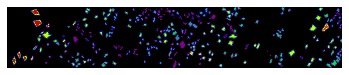

In [9]:
base_net=BaseNet(N_BANDS,N_CLASSES)
critirian=nn.CrossEntropyLoss().cuda()
lr=0.01
epochs=200
optimizer=torch.optim.SGD(base_net.parameters(),lr=lr,weight_decay=0.0001)
best_acc=0
kappa=0
cls_report=''
train_acc_list=[]
test_acc_list=[]
tic0 = time.perf_counter()
train(base_net,optimizer,critirian,train_loader,val_loader,epochs)
toc0 = time.perf_counter()
time_train = toc0 - tic0

tic = time.perf_counter()
number = 0
correct = 0
predicts = np.zeros((0))
targets = np.zeros((0))
indicesX = []
indicesY = []
with torch.no_grad():
    for iter_, (data, target,x,y) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        base_net.eval()
        output = base_net(data)
        _, predict = torch.max(output.data, 1)
        predict = predict.cpu().numpy()
        target = target.cpu().numpy()
        predicts = np.append(predicts, predict)
        targets = np.append(targets, target)
        indicesX.extend(x.cpu().numpy().tolist())
        indicesY.extend(y.cpu().numpy().tolist())
toc = time.perf_counter()
time_test = toc - tic
predicts = predicts.tolist()

targets = targets.tolist()
acc = accuracy_score(predicts, targets)
test_acc_list.append(acc)
toc = time.perf_counter()
time_test = toc - tic
print('test-------')
# print('Epoch:', epoch)
print('test Acc:', acc)
kappa = cohen_kappa_score(predicts, targets)
print('Kappa', kappa)
con_matrics = confusion_matrix(predicts, targets)
each_acc, aa = AA_andEachClassAccuracy(con_matrics)
cls_report = classification_report(predicts, targets, digits=4)
#         print(con_matrics)
#         print(cls_report)
print('aa:',aa)
print('each acc:',each_acc)
print('train time:',time_train)
print('test time:',time_test)

X = np.array(indicesX)
Y = np.array(indicesY)
test_img = gt
predicts_cor = [i+1 for i in predicts]
test_img[X[:], Y[:]] = np.array(predicts_cor)
plt.imshow(test_img, cmap='nipy_spectral')
plt.axis('off')
# plt.title("epoch:{}".format(epoch))
plt.show()


# classification maps for all pixels

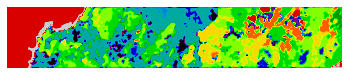

In [10]:
y_temp = np.ones_like(gt)
all_dataset = HSIdata(img,y_temp)
all_map_loader = torch.utils.data.DataLoader(all_dataset,
                               batch_size=256,
                               shuffle=True)

number = 0
correct = 0
predicts = np.zeros((0))
targets = np.zeros((0))
indicesX = []
indicesY = []
tic_all = time.perf_counter()
with torch.no_grad():
    for iter_, (data, target,x,y) in enumerate(all_map_loader):
        data, target = data.to(device), target.to(device)
        base_net.eval()
        output = base_net(data)
        _, predict = torch.max(output.data, 1)
        predict = predict.cpu().numpy()
        target = target.cpu().numpy()
        predicts = np.append(predicts, predict)
        targets = np.append(targets, target)
        indicesX.extend(x.cpu().numpy().tolist())
        indicesY.extend(y.cpu().numpy().tolist())
toc_all = time.perf_counter()
time_all = toc_all - tic_all
# print('inference all pixels time:',time_all)

predicts = predicts.tolist()
X = np.array(indicesX)
Y = np.array(indicesY)
test_img = gt
predicts_cor = [i+1 for i in predicts]
test_img[X[:], Y[:]] = np.array(predicts_cor)
plt.imshow(test_img, cmap='nipy_spectral')
plt.axis('off')
# plt.title("epoch:{}".format(epoch))
plt.show()
# io.savemat( dataset_name + 'LS2CM_all_classmap.mat', {"classes_map": test_img})


# model complexity

In [11]:
input_x = torch.randn(1, N_BANDS, 11, 11)
input_x = input_x.cuda()
macs, params = profile(base_net, inputs=(input_x, ))
print("macs:",macs,"params:",params)
summary(base_net, input_size=(N_BANDS,11,11))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class '__main__.LS2CM'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.ResLS2CM'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.BaseNet'>. Treat it as zero Macs and zero Params.
macs: 1398624.0 params: 12268.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 